# Problem Statement -
Build your own recommendation system for products on an e-commerce website like Amazon.com.


Dataset - ​ Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) - ratings_Electronics_Ver3.tar.xzView in a new window (you may use winrar application to extract the .csv file)

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.


o The repository has several datasets. For this case study, please use the Electronics dataset.

o The host page has several pointers to scripts and other examples that can help with parsing the datasets.

o The data set consists of:

    ● 7,824,482 Ratings (1-5) for Electronics products.
    ● Other metadata about products. Please see the description of the fields available on the web page cited above.


o For convenience of future use, parse the raw data file (using Python, for example) and extract the following fields: 'product/productId' as prod_id, 'product/title' as prod_name, 'review/userId' as user id, 'review/score' as rating

o Save these to a tab separated file. Name this file as product_ratings.csv.

In [107]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import Recommenders as Recommenders
import Evaluation as Evaluation

import random
from sklearn.metrics import mean_squared_error
from math import sqrt

%config IPCompleter.greedy=True

## 1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [108]:
# Load the dataset from csv file
ratings_df = pd.read_csv('ratings_Electronics.csv', error_bad_lines=False)

# Define the columns
ratings_df.columns = ['user_id', 'item_id', 'score', 'timestamp']

In [109]:
# Explore the datatypes and shape of the dataset
ratings_df.info()
print ("\n ratings data shape: ",  ratings_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
user_id      object
item_id      object
score        float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB

 ratings data shape:  (7824481, 4)


In [110]:
# Visualize the data by getting the top 5 rows
ratings_df.head()

,user_id,item_id,score,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [111]:
# Checking for missing value
print ("Count of null values in each feature:\n", ratings_df.isna().sum())

Count of null values in each feature:
 user_id      0
item_id      0
score        0
timestamp    0
dtype: int64


#### There are no missing values...

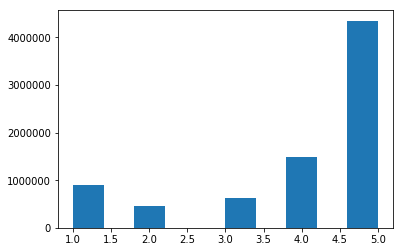

In [112]:
# Visualize the spread of ratings in the dataset
plt.hist(ratings_df.score)
plt.xlabel = 'Ratings'
plt.ylabel = 'Frequency'

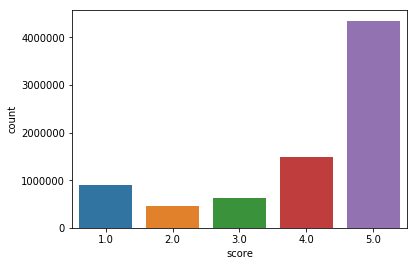

In [145]:
sns.countplot(data=ratings_df , x='score')
plt.show()

#### The more frequency is towards the high ratings. Ratings are not normally distributed.

In [113]:
# Get the mean ratings for each items and visualize
ratings_summary_df = pd.DataFrame()
ratings_summary_df['mean_score'] = ratings_df.groupby('item_id')['score'].mean()
ratings_summary_df.head()

,mean_score
item_id,
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852
0558835155,3.000000


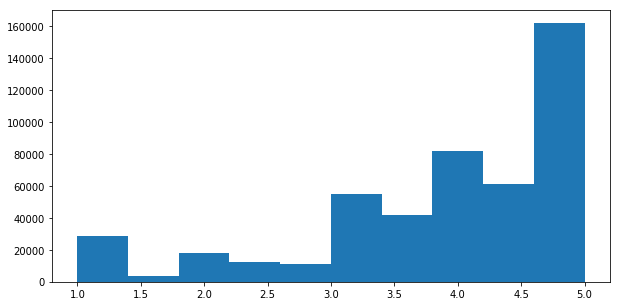

In [114]:
# Visualize the spread of ratings in the dataset
fig = plt.figure(figsize=(10 , 5))
plt.hist(ratings_summary_df.mean_score)
plt.xlabel = "Mean Ratings"
plt.ylabe = 'Frequency'
plt.show()

#### High frequency is towards high rating.

In [115]:
# Get the count of rating given by each users. This will help us to reduce the sparse data by 
# eliminating users who have not rated any items or less items
User_summary_df = pd.DataFrame()
User_summary_df['number_of_scores'] = ratings_df.groupby('user_id')['score'].count()
User_summary_df.head()

,number_of_scores
user_id,
A00000262KYZUE4J55XGL,1
A000063614T1OE0BUSKUT,2
A00009182QVLSWIGHLS1B,1
A00009661LC9LQPGKJ24G,1
A00010809P09NUU6ZP6H,1


In [116]:
User_summary_df['number_of_scores'].unique()

array([  1,   2,   4,   3,   6,   7,   5,   8,  10,   9,  11,  12,  21,
        14,  19,  15,  13,  18,  17,  25, 116, 132,  20,  22,  16,  26,
        27,  24,  23,  32,  68,  71,  38,  36,  35,  30,  40,  34,  65,
        39,  33,  41,  31,  28,  57,  96,  80, 107,  46, 123,  77, 130,
        52,  29,  89,  37, 112,  67,  86,  66,  45,  75, 205,  58,  50,
       216,  43,  92,  54,  49,  64,  51, 252,  42,  72,  81,  44,  74,
        47,  53,  48,  62,  70, 104, 102,  60,  63, 157,  99,  56,  55,
        61, 261, 151,  94,  78, 119,  83,  73, 144, 177, 149, 106,  82,
        69, 108, 196,  76, 221, 197, 200, 155, 208, 207, 181, 160, 213,
        59, 103,  85,  98, 145, 218,  84, 101,  91, 100,  88, 114,  79,
        93, 131, 142, 380,  90,  95, 126, 110, 105,  97, 167, 227, 128,
       127, 247, 129, 220, 121,  87, 202, 109, 156, 111, 162, 240, 125,
       137, 150, 292, 270, 115, 226, 296, 311, 176, 170, 122, 117, 159,
       277, 238, 120, 253, 138, 171, 136, 314, 282, 236, 257, 20

(0, 10000)

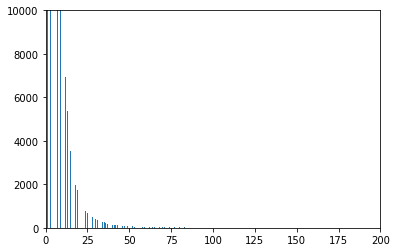

In [117]:
# Visualize the user ratings count.
plt.hist(User_summary_df.number_of_scores, bins=2000)
plt.xlabel = 'Users: No. of scores'
plt.ylabel = 'Frequency'
plt.xlim(xmin=0, xmax = 200)
plt.ylim(ymin=0, ymax = 10000)

#### We have more users who have not rated any items or rated less items (< 50).

## Observations:

### We have very sparse data (7824481 rows).
### UserID and itemID are alphanumeric. If needed we can convert it to category.
### timestamp column will not be of use for our evaluation here. So we can drop it.
### We have more data with higher ratings.
### We have more users who have not rated any items or rated less items.

## 2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [118]:
# Get the count of user who have rated more than 49 ratings
print (len(User_summary_df[User_summary_df.number_of_scores >= 50]))
print (len(User_summary_df[User_summary_df.number_of_scores < 50]))

1540
4200156


In [119]:
# Get the users who have rated >= 50 items.
Users_df = User_summary_df[User_summary_df.number_of_scores >= 50]
Users_df.index

Index(['A100UD67AHFODS', 'A100WO06OQR8BQ', 'A105S56ODHGJEK', 'A105TOJ6LTVMBG',
       'A10AFVU66A79Y1', 'A10H24TDLK2VDP', 'A10NMELR4KX0J6', 'A10O7THJ2O20AG',
       'A10PEXB6XAQ5XF', 'A10X9ME6R66JDX',
       ...
       'AYOTEJ617O60K', 'AYP0YPLSP9ISM', 'AZ515FFZ7I2P7', 'AZ8XSDMIX04VJ',
       'AZAC8O310IK4E', 'AZBXKUH4AIW3X', 'AZCE11PSTCH1L', 'AZMY6E8B52L2T',
       'AZNUHQSHZHSUE', 'AZOK5STV85FBJ'],
      dtype='object', name='user_id', length=1540)

In [120]:
# Have only users who have rated >=50 for our prediction and evaluation.
ratings_subset_df = ratings_df.loc[(ratings_df['user_id'].isin(Users_df.index))]
ratings_subset_df.shape

(125871, 4)

In [121]:
# Drop the timestamp column as we will not be using in our predictions
ratings_subset_df.drop('timestamp', axis = 1, inplace = True)

C:\Users\Iyyappan\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Observations:

### We have created the subset of data to reduce the sparseness by droping the users who have rated <50 items.

## 3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [122]:
# Lets split the data to Train, Test
train_data, test_data = train_test_split(ratings_subset_df, test_size = 0.30, random_state=100)
print(train_data.head(5))

                user_id     item_id  score
5993537   ANW6EGY12V5XS  B007ZW43IQ    4.0
4459174  A1QVFHPY8418HC  B004T9Y0MW    5.0
2177399   ALDAF4VVLFRHP  B001NOG2T0    4.0
232286   A11YIHB6IW352W  B00007KDVI    5.0
7811982  A3PD8JD9L4WEII  B00JGSWU7S    5.0


In [123]:
# Lets have the splitted test data also in the training set without any ratings. 
# This will help us in the evaluation later.

# Get the copy of test data.
TempTest = test_data.copy()

# remove all the ratings in the test data copy.
TempTest.rating = np.nan

In [124]:
# Drop all the nan values in test data.
test_data = test_data.dropna()

# Merge the training and temp test data (without ratings)
train_data = pd.concat([train_data, TempTest])

## Observations:

### We have splitted the data into train and test (70:30)
### But we have merged the test data (without ratings) with the training data to help us in evaluation later.
### If the above step is not done, we might miss predictions and evaluation for some users and items.

## 4. Build Popularity Recommender model.

In [125]:
# Used the seperate module recommender.py
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'item_id')

In [126]:
# Get the unique users in train dataset to get recommendation for users.
train_users = train_data['user_id'].unique()

In [127]:
# Get top 10 recommendation for a user.
pm.recommend(train_users[7]).head(10)

,user_id,item_id,score,Rank
0,A27TN8D0CZ8LUY,0594451647,5.0,1.0
5,A27TN8D0CZ8LUY,1400501520,5.0,2.0
12,A27TN8D0CZ8LUY,1400699169,5.0,3.0
13,A27TN8D0CZ8LUY,1685560148,5.0,4.0
14,A27TN8D0CZ8LUY,3744295508,5.0,5.0
16,A27TN8D0CZ8LUY,787988002X,5.0,6.0
17,A27TN8D0CZ8LUY,8862935307,5.0,7.0
21,A27TN8D0CZ8LUY,9573212919,5.0,8.0
23,A27TN8D0CZ8LUY,9800359788,5.0,9.0
26,A27TN8D0CZ8LUY,9981739588,5.0,10.0


In [128]:
# Get top 10 recommendation for a user.
pm.recommend(train_users[234]).head(10)

,user_id,item_id,score,Rank
0,A1PVX61PRPVX27,0594451647,5.0,1.0
5,A1PVX61PRPVX27,1400501520,5.0,2.0
12,A1PVX61PRPVX27,1400699169,5.0,3.0
13,A1PVX61PRPVX27,1685560148,5.0,4.0
14,A1PVX61PRPVX27,3744295508,5.0,5.0
16,A1PVX61PRPVX27,787988002X,5.0,6.0
17,A1PVX61PRPVX27,8862935307,5.0,7.0
21,A1PVX61PRPVX27,9573212919,5.0,8.0
23,A1PVX61PRPVX27,9800359788,5.0,9.0
26,A1PVX61PRPVX27,9981739588,5.0,10.0


In [129]:
# Funtion to get mean RMSE for the Popularity Recommender model for random 10 users in test data.
def GetpmRMSE():
    # As the prediction is going to be same for all the users, lets have the commen predicted DataFram.
    
    uuid = test_data['user_id'].unique()
    rand_uuid = random.sample(list(uuid), 10)
    arr_RMSE = []
    RMSE = -1
    for ruid in rand_uuid:
        #print (ruid)
        UserPred = pm.recommend(ruid)
        #print ("UIID: " + str(len(UserPred)))
        Actual = test_data[test_data.user_id == ruid]
        UserPred = UserPred[UserPred['item_id'].isin(Actual['item_id'].unique())]
        Actual = Actual[Actual['item_id'].isin(UserPred['item_id'].unique())]
        uiid = Actual['item_id'].unique()
        #print ("UIID: " + str(len(uiid)))
        if len(uiid) > 0:
            arr_Actual = []
            arr_Pred = []
            score = 0
            error = 0
            for uid in uiid:
                score = Actual[Actual.item_id == uid]['score']
                arr_Actual.append(score.values[0])
                score = UserPred[UserPred.item_id == uid]['score']
                arr_Pred.append(score.values[0])
                error = sqrt(mean_squared_error(arr_Actual, arr_Pred))
                arr_RMSE.append(error)
                #print (error)
    RMSE = np.average(arr_RMSE)
    return RMSE

## Observations:

### We can see same set of recommendation for all the users as this model is not user specific.
### This model gives recommendations based on popularity of the item.
### Lets calculate the accuracy and compare with Collaborative model in the upcoming steps.

## 5. Build Collaborative Filtering model.

#### surprise toolkit is used for Collaborative Filtering model.

In [130]:
# Import all the necessary surprise toolkit modules...

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [131]:
# Lets load the dataset as per the requirement for surprise module
reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(ratings_subset_df, reader = reader)

In [132]:
# Lets split the train and test with surprise model functionality
trainset, testset = train_test_split(data, test_size=.3)

In [133]:
# Lets go with KNN algorithm
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})

# Train the model with train dataset
algo.fit(data.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [134]:
# This function gives the top N predictions for the users based on collaborative filtering model.
def predictItem(uid, N=10):
    #Get the list of item id's already rated by the user.
    iidUsr = ratings_subset_df.loc[ratings_subset_df['user_id'] == uid, 'item_id']
    #Remove the item id's already rated by the user
    iids_to_pred = np.setdiff1d(itemIDs,iidUsr)
    testpredict = [[uid, iid, 4.] for iid in iids_to_pred]
    pred = algo.test(testpredict)
    pred_df = pd.DataFrame(pred)
    SortedPred = pd.DataFrame()
    SortedPred['iid'] = pred_df['iid']
    SortedPred['est'] = pred_df['est']
    SortedPred.sort_values(by = 'est', inplace= True, ascending=False)
    print ("Top {} item predictions for the user {}:".format(N, uid) )
    print (SortedPred.head(N))

In [135]:
#Lets predict top 5 recommendation for some user
predictItem('A2OT3PDH1AWLTG', 10)

Top 10 item predictions for the user A2OT3PDH1AWLTG:
              iid  est
38561  B00829THVO  5.0
43090  B00B7Y7PQU  5.0
14295  B0013CED4I  5.0
17365  B001IWX9A2  5.0
33814  B005IN09GO  5.0
8181   B000E5E868  5.0
32376  B0055EB9LK  5.0
45227  B00DVFLJDS  5.0
21890  B002QGDWLK  5.0
33809  B005IMFX2K  5.0


In [136]:
predictItem(train_users[100], 10)

Top 10 item predictions for the user ABMF4UC4Z00NT:
              iid  est
19317  B001XUR5FO  5.0
41762  B009YKTR06  5.0
19488  B00243HHNY  5.0
6683   B000922KLQ  5.0
46381  B00FW3KZNM  5.0
6677   B00091R6KC  5.0
29514  B004HYG9V4  5.0
1793   B00006B12C  5.0
29505  B004HW7KF0  5.0
6647   B00085FGVU  5.0


In [137]:
#To get the item specific rating for a user
algo.predict('A2NYOY6H42SORF', 'B003XIM3QK', r_ui=4, verbose=True)

user: A2NYOY6H42SORF item: B003XIM3QK r_ui = 4.00   est = 2.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2NYOY6H42SORF', iid='B003XIM3QK', r_ui=4, est=2.0, details={'actual_k': 1, 'was_impossible': False})

In [138]:
# Get all unique item id's in the dataset
#itemIDs = ratings_subset_df['item_id'].unique()

## Observations:

### Differnt recommendations are given for different users, as Collaborative Filtering model is based on user preferrences unlike Popularity Model.
### Lets calculate the RMSE on test set and compare with Popularity model.

## 6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [139]:
# Evaluation for Popularity Model.

# This function will get the predictions for 10 random users in test dataset and will calculate the RMSE.
print("Popularity Model RMSE: ", GetpmRMSE())

Popularity Model RMSE:  0.5485657558964333


In [140]:
# Evaluation for Collaborative Filtering Model.

# Lets predict for test data and get the RMSE for the prediction.
predictions = algo.test(testset)                                           
print ("Collaborative Model RMSE: ", accuracy.rmse(predictions))

RMSE: 0.0330
Collaborative Model RMSE:  0.03299205624118519


## Observations:

### Collaborative model have given the better accuracy (less error) than Popularity Model.
### As Collaborative model is based on user/item charecteristics, it will be more accurate than Popularity Model.

## 7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [141]:
# Get unique users in the dataset.
Users = ratings_subset_df['user_id'].unique()

In [142]:
# Top 5 recommendation using Popularity Model
pm.recommend(Users[115]).head(5)

,user_id,item_id,score,Rank
0,A1J75JJ0Q2OEJN,0594451647,5.0,1.0
5,A1J75JJ0Q2OEJN,1400501520,5.0,2.0
12,A1J75JJ0Q2OEJN,1400699169,5.0,3.0
13,A1J75JJ0Q2OEJN,1685560148,5.0,4.0
14,A1J75JJ0Q2OEJN,3744295508,5.0,5.0


In [143]:
# Top 5 recommendation using Collaborative Filtering Model
predictItem(Users[115], 5)

Top 5 item predictions for the user A1J75JJ0Q2OEJN:
              iid  est
46876  B00HA236FC  5.0
40852  B009CP99GK  5.0
18847  B001TIHVHC  5.0
7595   B000BI6AH8  5.0
561    B00004WCFT  5.0


## 8. Summarize your insights.

### Popularity Model gives similar recommendation to all users.
### It is based on popularity of the items rather than user specific.
### Collaborative Model gives user specific recommendations as it considers user/item characteristics to recommend similar products.
### So Collaborative Filtering model will give precise recommendation than Popularity Model. It was evident with the RMSE scores of each models.